In [1]:
import pickle
import numpy as np
import os

import plotly.graph_objects as go
import plotly.offline as pyo
# import matplotlib as mpl
# import matplotlib.pyplot as plt
from plotly.subplots import make_subplots


def simulate_pre(
    grid = (), model_args = (), controls = (), initial=(np.log(85/0.115), 1.1, np.log(1/120)), 
    T0=0, T=40, dt=1/12,
    printing=False):

    K, Y, L = grid

    if printing==True:
        print("K_min={},K_max={},Y_min={},Y_max={},L_min={},L_max={}" .format(K.min(),K.max(),Y.min(),Y.max(),L.min(),L.max()))

    K_min, K_max, Y_min, Y_max, L_min, L_max = min(K), max(K), min(Y), max(Y), min(L), max(L)
    hK, hY = K[1] - K[0], Y[1] - Y[0]
    (K_mat, Y_mat, L_mat) = np.meshgrid(K, Y, L, indexing = 'ij')

    delta, mu_k, kappa, sigma_k, beta_f, zeta, psi_0, psi_1, sigma_g, theta, lambda_bar, vartheta_bar, = model_args
    ii, ee, xx, g_tech, g_damage, pi_c = controls
    n_climate = len(pi_c)

    method = 'linear'
    years  = np.arange(T0, T0 + T + dt, dt)
    pers   = len(years)
       

    # setting up grids
    stateSpace = np.hstack([
        K_mat.reshape(-1,1,order = "F"), 
        Y_mat.reshape(-1,1,order = "F"),
        L_mat.reshape(-1,1,order = "F"),
    ])

    # some parameters remaiend unchanged across runs
    gamma_1  = 0.00017675
    gamma_2  = 2. * 0.0022
    beta_f   = 1.86 / 1000
    sigma_y  = 1.2 * 1.86 / 1000
    
    theta_ell = pd.read_csv("./data/model144.csv", header=None).to_numpy()[:, 0]/1000.
    pi_c_o = np.ones(len(theta_ell)) / len(theta_ell)
    pi_c_o = np.array([temp * np.ones(K_mat.shape) for temp in pi_c_o])
    theta_ell = np.array([temp * np.ones(K_mat.shape) for temp in theta_ell])
    args = (delta, alpha, kappa, mu_k, sigma_k, gamma_1, gamma_2, theta_ell, pi_c_o, sigma_y,  theta, vartheta_bar, lambda_bar)

#     v, ME_base, diff = decompose(v0, stateSpace, (K_mat, Y_mat, L_mat), (ii, ee, xx), args=args)

    gridpoints = (K, Y, L)

    i_func = RegularGridInterpolator(gridpoints, ii)
    e_func = RegularGridInterpolator(gridpoints, ee)
    x_func = RegularGridInterpolator(gridpoints, xx)
    tech_func = RegularGridInterpolator(gridpoints, g_tech)
#     ME_base_func = RegularGridInterpolator(gridpoints, ME_base)
    
#     if pre_damage:
    n_damage = len(g_damage)

    damage_func_list = []
    for i in range(n_damage):
        func_i = RegularGridInterpolator(gridpoints, g_damage[i])
        damage_func_list.append(func_i)
        
    climate_func_list = []
    for i in range(n_climate):
        func_i = RegularGridInterpolator(gridpoints, pi_c[i])
        climate_func_list.append(func_i)


    def get_i(x):
        return i_func(x)

    def get_e(x):
        return e_func(x)
    
    def get_x(x):
        return x_func(x)


#     K_0 = np.log(85 / 0.115)
#     Y_0 = 1.1
#     L_0 = -3.7
    
    K_0, Y_0, L_0 = initial

    def mu_K(i_x):
        return mu_k + i_x - 0.5 * kappa * i_x ** 2  - 0.5 * sigma_k ** 2
    
    def mu_L(Xt, state):
        return -zeta + psi_0 * (Xt * (np.exp(state[0] - state[2]) ) )**psi_1 - 0.5 * sigma_g**2
    
    
    hist      = np.zeros([pers, 3])
    i_hist    = np.zeros([pers])
    e_hist    = np.zeros([pers])
    x_hist    = np.zeros([pers])
    scc_hist  = np.zeros([pers])
    gt_tech   = np.zeros([pers])
#     if pre_damage:
    gt_dmg    = np.zeros([n_damage, pers])
    pi_c_t = np.zeros([n_climate, pers])
    
#     ME_base_t = np.zeros([pers])

    mu_K_hist = np.zeros([pers])
    mu_L_hist = np.zeros([pers])

    for tm in range(pers):
        if tm == 0:

            # initial points
            hist[0,:] = [K_0, Y_0, L_0] # logL
            i_hist[0] = get_i(hist[0, :])
            e_hist[0] = get_e(hist[0, :])
            x_hist[0] = get_x(hist[0, :])
            mu_K_hist[0] = mu_K(i_hist[0])
            mu_L_hist[0] = mu_L(x_hist[0], hist[0,:])
            gt_tech[0] = tech_func(hist[0, :])
#             if pre_damage:
            for i in range(n_damage):
                damage_func = damage_func_list[i]
                gt_dmg[i, 0] = damage_func(hist[0, :])
            
            for i in range(n_climate):
                climate_func = climate_func_list[i]
                pi_c_t[i, 0] = climate_func(hist[0, :])
            
#             gt_dmg[0] = damage_func(hist[0, :])
#             ME_base_t[0] = ME_base_func(hist[0, :])
            
#             scc_hist[0] = scc_func(hist[0, :])

        else:
            # other periods
            # print(hist[tm-1,:])
            i_hist[tm] = get_i(hist[tm-1,:])
            e_hist[tm] = get_e(hist[tm-1,:])
            x_hist[tm] = get_x(hist[tm-1,:])
            gt_tech[tm] = tech_func(hist[tm-1,:])
#             if pre_damage:
            for i in range(n_damage):
                damage_func = damage_func_list[i]
                gt_dmg[i, tm] = damage_func(hist[tm-1, :])

            for i in range(n_climate):
                climate_func = climate_func_list[i]
                pi_c_t[i, tm] = climate_func(hist[tm -1, :])
                
#             ME_base_t[tm] = ME_base_func(hist[tm-1, :])
            

            mu_K_hist[tm] = mu_K(i_hist[tm])
            mu_L_hist[tm] = mu_L(x_hist[tm], hist[tm-1, :])

            hist[tm,0] = hist[tm-1,0] + mu_K_hist[tm] * dt #logK
            hist[tm,1] = hist[tm-1,1] + beta_f * e_hist[tm] * dt
            hist[tm,2] = hist[tm-1,2] + mu_L_hist[tm] * dt # logλ

        if printing==True:
            print("time={}, K={},Y={},L={},mu_K={},mu_Y={},mu_L={},ii={},ee={},xx={}" .format(tm, hist[tm,0],hist[tm,1],hist[tm,2],mu_K_hist[tm],beta_f * e_hist[tm],mu_L_hist[tm],ii.max(),ee.max(),xx.max()))
        
    
    
        # using Kt instead of K0
    jt = 1 - e_hist/ (alpha * lambda_bar * np.exp(hist[:, 0]))
    jt[jt <= 1e-16] = 1e-16
    LHS = theta * vartheta_bar / lambda_bar * jt**(theta -1)
    MC = delta / (alpha  - i_hist - alpha * vartheta_bar * jt**theta - x_hist)

    
    scc_hist = LHS * 1000
#     scc_0 = ME_base_t / MC * 1000 * np.exp(hist[:, 0])
    
    distorted_tech_intensity = np.exp(hist[:, 2]) * gt_tech
    distorted_tech_prob = 1 - np.exp(- np.cumsum(np.insert(distorted_tech_intensity * dt, 0, 0) ))[:-1]

    true_tech_intensity = np.exp(hist[:, 2]) 
    true_tech_prob = 1 - np.exp(- np.cumsum(np.insert(true_tech_intensity * dt, 0, 0) ))[:-1]
        
#     if pre_damage:
    damage_intensity = Damage_Intensity(hist[:, 1])
    distorted_damage_intensity = np.mean(gt_dmg, axis=0) * damage_intensity
    distorted_damage_prob = 1 - np.exp(- np.cumsum(np.insert(distorted_damage_intensity * dt, 0, 0) ))[:-1]
    
    true_damage_intensity =  damage_intensity
    true_damage_prob = 1 - np.exp(- np.cumsum(np.insert(true_damage_intensity * dt, 0, 0) ))[:-1]

    
    res = dict(
        states= hist, 
        i = i_hist * np.exp(hist[:, 0]), 
        e = e_hist,
        # x = x_hist * np.exp(hist[:, 0]),
        x = x_hist * np.exp(hist[:, 0]),
        scc = scc_hist,
#         scc0 = scc_0,
        gt_tech = gt_tech,
        gt_dmg = gt_dmg,
        distorted_damage_prob=distorted_damage_prob,
        distorted_tech_prob=distorted_tech_prob,
        pic_t = pi_c_t,
#         ME_base = ME_base_t,
        jt = jt,
        LHS = LHS,
        years=years,
        true_tech_prob = true_tech_prob,
        true_damage_prob = true_damage_prob
    )
    
#     if pre_damage:
#         res["gt_dmg"] = gt_dmg
    
    return res


mpl.rcParams["lines.linewidth"] = 2.5
mpl.rcParams["savefig.bbox"] = "tight"
mpl.rcParams["figure.figsize"] = (8,5)
mpl.rcParams["font.size"] = 13
# mpl.rcParams["legend.frameon"] = False
mpl.rcParams["legend.frameon"] = True
mpl.rcParams["legend.framealpha"] = 1


psi_0 = 0.010
psi_1 = 0.800

with open("./data_2tech/moreiteration/xi_a_1000.0_xi_g_1000.0_psi_0_0.01_psi_1_0.8_model_tech2_pre_damage", "rb") as f:
    data = pickle.load(f)

In [ ]:
import plotly.graph_objects as go


In [2]:
import os
import pickle

In [2]:
data["v0"].shape

(51, 31, 54)

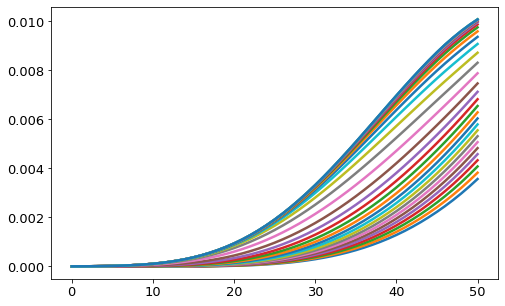

In [3]:
plt.plot(data["x_star"][:, :, 6])
plt.show()

In [13]:
delta = 0.01
alpha = 0.115
kappa = 6.667
mu_k  = -0.043
sigma_k = 0.0095
beta_f = 1.86/1000
sigma_y = 1.2 * 1.86 / 1000
zeta = 0.0

sigma_g = 0.016
gamma_1 = 1.7675 / 1000
gamma_2 = 0.0022 * 2
NUM_DAMAGE = 6
gamma_3_list = np.linspace(0., 1./3., NUM_DAMAGE)
y_bar = 2.
y_bar_lower = 1.5


# Tech
theta = 3
lambda_bar = 0.1206
vartheta_bar = 0.0453

lambda_bar_first = lambda_bar / 2.
vartheta_bar_first = vartheta_bar / 2.

lambda_bar_second = 1e-3
vartheta_bar_second = 0.

K_min = 4.00
K_max = 9.00
hK    = 0.10
K     = np.arange(K_min, K_max + hK, hK)
nK    = len(K)
Y_min = 0.
Y_max = 4.
hY    = 0.10 # make sure it is float instead of int
Y     = np.arange(Y_min, Y_max + hY, hY)
nY    = len(Y)
L_min = - 5.5
L_max = - 0.
hL    = 0.10
L     = np.arange(L_min, L_max,  hL)
nL    = len(L)


id_2 = np.abs(Y - y_bar).argmin()
Y_min_short = 0.
Y_max_short = 3
Y_short     = np.arange(Y_min_short, Y_max_short + hY, hY)
nY_short    = len(Y_short)

(K_mat, Y_mat, L_mat) = np.meshgrid(K, Y_short, L, indexing="ij")

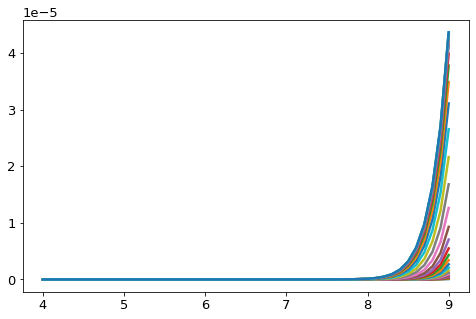

In [8]:
import matplotlib.pyplot as plt

plt.plot(K, data["x_star"][:, :, -5])
plt.show()

In [19]:
np.exp(L[7]),1/120

(0.008229747049020008, 0.008333333333333333)

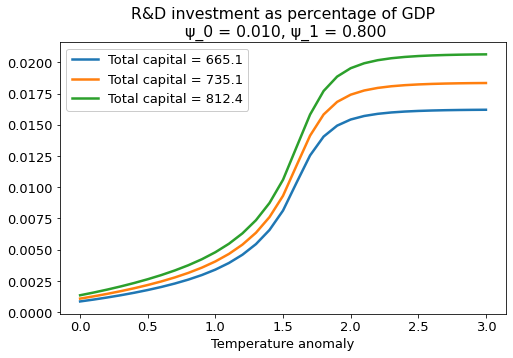

In [23]:

import matplotlib.ticker as mtick

fig, ax = plt.subplots()
plt.plot(Y_short, data["x_star"][25:28 , :, 7].T / alpha)
plt.xlabel("Temperature anomaly")
plt.title("R&D investment as percentage of GDP\n ψ_0 = {:.3f}, ψ_1 = {:.3f}".format(psi_0, psi_1))
# ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(["Total capital = {:.1f}".format(np.exp(K[i])) for i in [25, 26, 27]])
# plt.savefig("figures/x_Y.pdf")
plt.show()

In [29]:
from src.supportfunctions import finiteDiff_3D

v0 = data["v0"]
dK = finiteDiff_3D(v0, 0, 1, hK)
dY = finiteDiff_3D(v0, 1, 1, hY)
dL = finiteDiff_3D(v0, 2, 1, hL)

ddK = finiteDiff_3D(v0, 0, 2, hK)
ddY = finiteDiff_3D(v0, 1, 2, hY)
ddL = finiteDiff_3D(v0, 2, 2, hL)

Y_min_short = 0.
Y_max_short = 3.
Y_short     = np.arange(Y_min_short, Y_max_short + hY, hY)

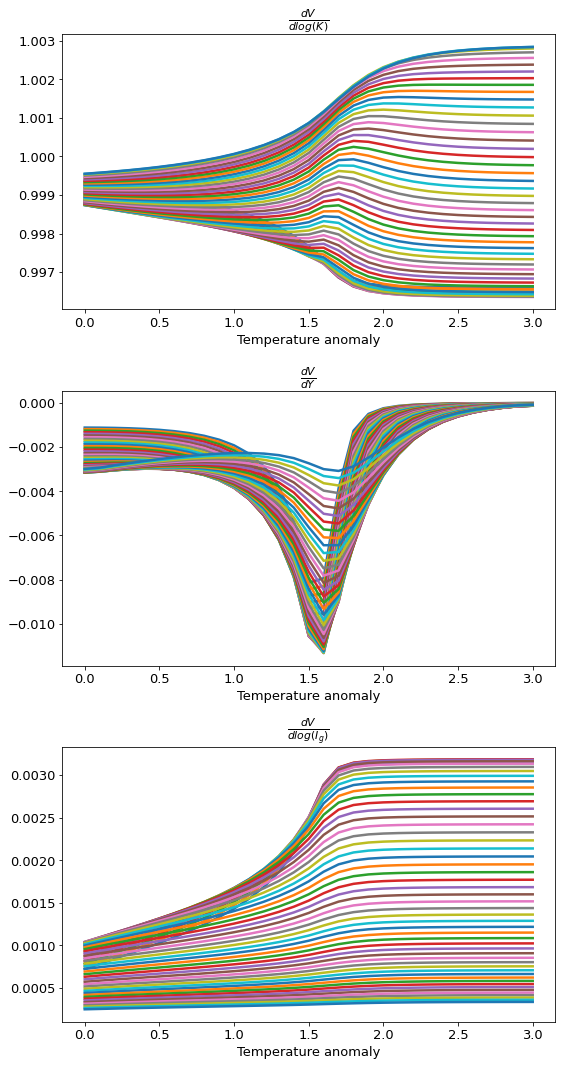

In [30]:
plt.figure(figsize=(8,15))
plt.subplot(311)
plt.plot(Y_short, dK[:, :, 6].T)
plt.xlabel("Temperature anomaly")
plt.title(r"$\frac{d V}{d log(K)}$")
# plt.show()

plt.subplot(312)
plt.plot(Y_short, dY[:, :, 6].T)
plt.xlabel("Temperature anomaly")
plt.title(r"$\frac{d V}{d Y}$")
# plt.show()

plt.subplot(313)
plt.plot(Y_short, dL[:, :, 6].T)
plt.xlabel("Temperature anomaly")
plt.title(r"$\frac{d V}{d log(I_g)}$")

plt.tight_layout()


plt.savefig("./pdf_2tech/moreiteration/FirstOrder.pdf")
plt.show()

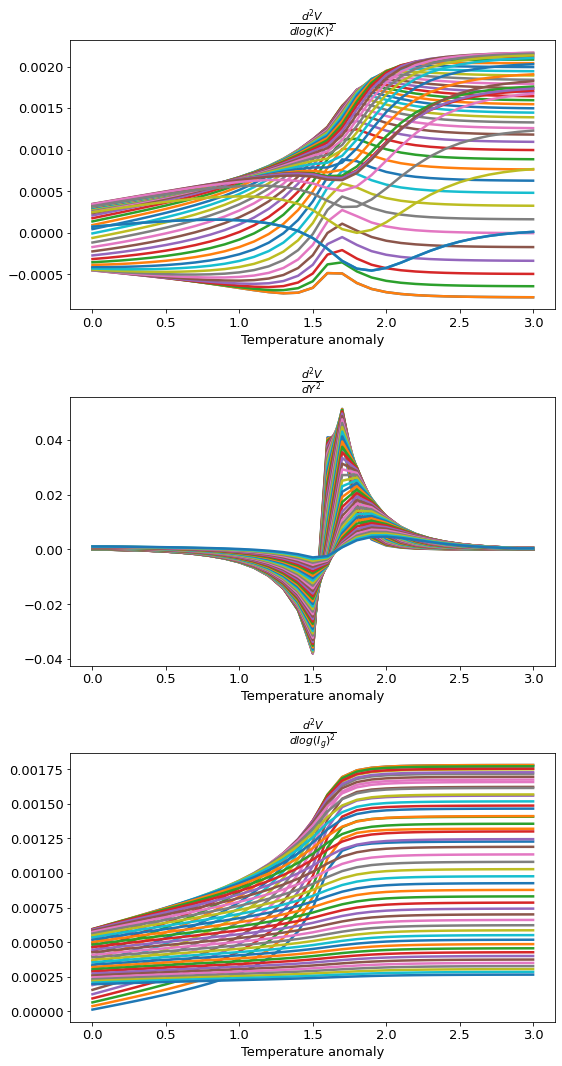

In [31]:
plt.figure(figsize=(8,15))
plt.subplot(311)
plt.plot(Y_short, ddK[:, :, 6].T)
plt.xlabel("Temperature anomaly")
plt.title(r"$\frac{d^2 V}{d log(K)^2}$")
# plt.show()

plt.subplot(312)
plt.plot(Y_short, ddY[:, :, 6].T)
plt.xlabel("Temperature anomaly")
plt.title(r"$\frac{d^2 V}{d Y^2}$")
# plt.show()

plt.subplot(313)
plt.plot(Y_short, ddL[:, :, 6].T)
plt.xlabel("Temperature anomaly")
plt.title(r"$\frac{d^2 V}{d log(I_g)^2}$")
plt.tight_layout()

plt.savefig("./pdf_2tech/moreiteration/SecondOrder.pdf")
plt.show()